In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

In [8]:
from seqjax.target.base import Target, Scalar, Hyperparameters, Particle
from seqjax.target.stochastic_vol import SimpleStochasticVol, LogVolRW, LastUnderlying
from seqjax.target.simulate import simulate

In [9]:
num_steps = 1000
hyperparameters = LogVolRW(log_vol_std=jnp.array(3.2), initial_underlying=jnp.array(3000.))
key = jrandom.key(21)
dt = jnp.array(1 / (256 * 8 * 60)) # 1 minute in 256 day 8 hr trading days 
condition = jax.vmap(LastUnderlying)(jnp.ones(num_steps) * dt)
target = SimpleStochasticVol()

x_path, y_path, observed_condition = simulate(
    key,
    target,
    condition,
    hyperparameters,
    num_steps=num_steps,
)

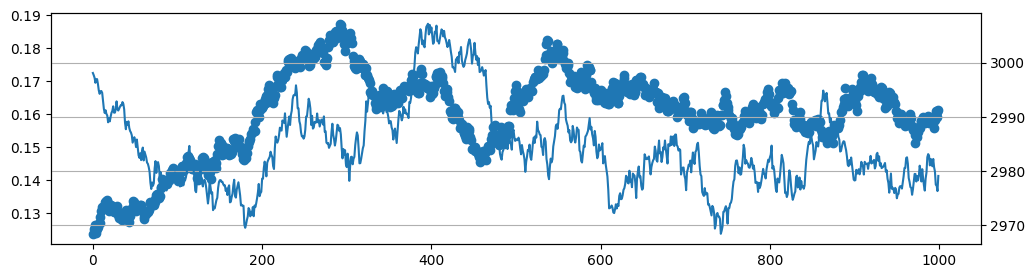

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.scatter(range(num_steps), jnp.exp(x_path.log_vol))
plt.twinx()
plt.plot(y_path.underlying)
plt.grid()

In [11]:
from functools import partial

def index_tree(ix, tree):
    return jax.tree.map(partial(jax.lax.dynamic_index_in_dim, index=ix, keepdims=False), tree)

def resample_from_log_weights(key, log_weights, particles):
    # gumbel max trick
    gumbels = -jnp.log(-jnp.log(
        jrandom.uniform(key, (log_weights.shape[0], log_weights.shape[0]))
    ))
    particle_ix = jnp.argmax(log_weights + gumbels, axis=1).reshape(-1)
    return jax.vmap(
        index_tree, in_axes=[0, None],
    )(particle_ix, particles)

def compute_esse_from_log_weights(log_weights):
    # ess efficiency, ie ess / M
    log_w = log_weights - jnp.max(log_weights)  # for numerical stability
    log_sum_w = jax.scipy.special.logsumexp(log_weights)
    log_sum_w2 = jax.scipy.special.logsumexp(2 * log_weights)
    ess = jnp.exp(2 * log_sum_w - log_sum_w2)
    return ess / log_w.shape[0]

def configure_basic_particle_filter(target, num_particles, key):
    proposal = jax.vmap(target.sample_transition, in_axes=[0, 0, None, None])
    incremental_weight = jax.vmap(target.emission_log_p, in_axes=[0, None, None, None])

    def basic_pf_step(key, log_weights, particles, observation, condition, hyperparameters):
        resample_key, proposal_key = jrandom.split(key)

        # resampling
        resample = compute_esse_from_log_weights(log_weights) < 0.5
        particles = jax.lax.cond(
            resample,
            lambda particles: resample_from_log_weights(resample_key, log_weights, particles),
            lambda particles: particles,
            particles
        )
        log_weights = jax.lax.select(resample, jnp.zeros_like(log_weights), log_weights)

        # proposal
        next_particles = proposal(
            jrandom.split(proposal_key, num_particles), 
            particles, 
            condition, 
            hyperparameters,
        )

        # weight accumulation
        log_weights += incremental_weight(
            next_particles, observation, condition, hyperparameters
        )
        return log_weights, next_particles

    log_weights = jnp.zeros([num_particles])
    init_particles = jax.vmap(target.sample_prior, in_axes=[0, None])(jrandom.split(key, num_particles), hyperparameters)

    return log_weights, init_particles, basic_pf_step

In [12]:
import tqdm.notebook as tqdm

num_particles = 1000
log_weights, particles, basic_pf_step = configure_basic_particle_filter(target, num_particles, key)
basic_pf_step = jax.jit(basic_pf_step)

q_05s = []
q_95s = []

# TODO: this should be a jax scan
for ix in tqdm.tqdm(range(num_steps)):
    observation = index_tree(ix, y_path)
    condition = index_tree(ix, observed_condition)

    key, step_key = jrandom.split(key)
    log_weights, particles = basic_pf_step(step_key, log_weights, particles, observation, condition, hyperparameters)

    p = resample_from_log_weights(step_key, log_weights, particles)
    q_05, q_95 = jnp.quantile(jnp.exp(particles.log_vol), jnp.array([0.05, 0.95]))
    q_05s.append(q_05)
    q_95s.append(q_95)

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_2215789/3638683409.py:4: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(partial(jax.lax.dynamic_index_in_dim, index=ix, keepdims=False), tree)


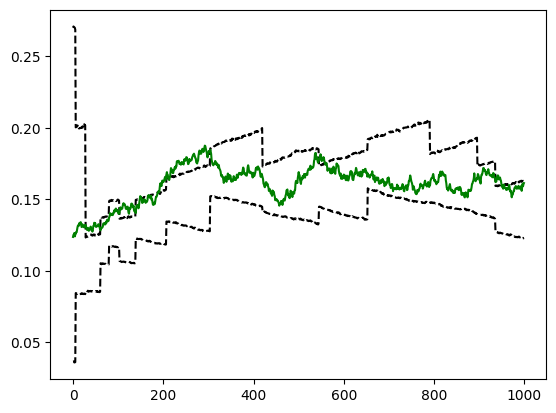

In [14]:
plt.plot(q_05s, linestyle='--', c='black')
plt.plot(q_95s, linestyle='--', c='black')
plt.plot(jnp.exp(x_path.log_vol), c='green')

(array([0.029444  , 0.06772111, 0.08538761, 0.10305394, 0.1619419 ,
        0.22966322, 0.27971782, 0.41516014, 0.69782236, 0.87448656]),
 array([-4.60066557, -4.26103783, -3.92140961, -3.58178186, -3.24215388,
        -2.9025259 , -2.56289816, -2.22327018, -1.8836422 , -1.54401422,
        -1.20438635]),
 <BarContainer object of 10 artists>)

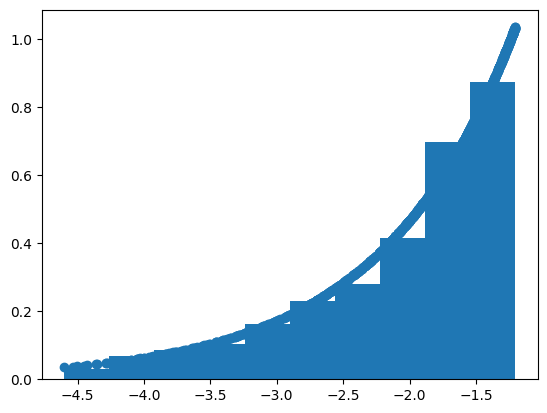

In [21]:
# plt.hist(jnp.exp(init_particles.log_vol), alpha=0.3)

log_p = jax.vmap(target.prior_log_p, in_axes=[0, None])(init_particles, hyperparameters)
# plt.hist(jnp.exp(next_particles['log_vol']), alpha=0.3)
# plt.scatter(init_particles.log_vol, jnp.exp(log_p))
# plt.hist(init_particles.log_vol, density=True)